# Machine Learning in Python - Project 1

Due Friday, March 6th by 5 pm.

## 1. Setup

### 1.1 Libraries

In [1]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_transformer
import time

### 1.2 Data

In [2]:
sales = pd.read_csv("sales.csv")
sales_test = pd.read_csv("sales_test.csv")

## 2. Exploratory Data Analysis and Preprocessing

*Include a discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up.*

*In this section you should also implement and describe any preprocessing / transformations of the features. Hint - you should not be modeling this data without transforming some of the features, e.g. modeling sale price directly is not a good idea.*

### 2.1 A glimpse on the dataset.

Looking at a few rows in the dataset.

In [3]:
sales

,sale_price,year_sold,year_built,lot_area,basement_area,living_area,full_bath,half_bath,bedroom,garage_cars,garage_area,ac,zoning,neighborhood,quality,condition
0,244000,2010,1968,11160,2110,2110,2,1,3,2,522,Y,Residential_Low_Density,nb_07,good,average
1,189900,2010,1997,13830,928,1629,2,1,3,2,482,Y,Residential_Low_Density,nb_22,average,average
2,191500,2010,1992,5005,1280,1280,2,0,2,2,506,Y,Residential_Low_Density,nb_10,good,average
3,236500,2010,1995,5389,1595,1616,2,0,2,2,608,Y,Residential_Low_Density,nb_10,good,average
4,189000,2010,1999,7500,994,1804,2,1,3,2,442,Y,Residential_Low_Density,nb_22,good,average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,79500,2006,1970,1526,546,1092,1,1,3,0,0,Y,Residential_Medium_Density,nb_02,average,average
1580,160000,2006,1977,17400,1126,1126,2,0,3,2,484,Y,Residential_Low_Density,nb_20,average,average
1581,142500,2006,1984,7937,1003,1003,1,0,3,2,588,Y,Residential_Low_Density,nb_20,average,average
1582,132000,2006,1992,10441,912,970,1,0,3,0,0,Y,Residential_Low_Density,nb_20,average,average


Take a look at the datatypes of the columns.

In [4]:
sales.dtypes

sale_price        int64
year_sold         int64
year_built        int64
lot_area          int64
basement_area     int64
living_area       int64
full_bath         int64
half_bath         int64
bedroom           int64
garage_cars       int64
garage_area       int64
ac               object
zoning           object
neighborhood     object
quality          object
condition        object
dtype: object

Column `ac`, `zoning`, `neighborhood`, `quality`, and `condition` are apparent categorical variables to be encoded. `full_bath` and `half_bath` can also be viewed as categorical variables. This is also mentioned in the `README.ipynb` file. 

### 2.2 Transform categorical variables using one hot encoding

Here, I would like to discuss how I would transform the categorical variables of this dataset, with rules specified in the `encoding` dictionary.

All the categorical features except `neighborhood` can be easily transformed. However, I decide to sort the `neighborhood` by their means. I will then transform it into an ordinal feature so that this feature can be fitted into a linear model.

In [5]:
rank_neighbor = sales[["sale_price", "neighborhood"]].groupby(['neighborhood'], as_index=False).mean()
rank_neighbor.sort_values("sale_price", inplace=True)
ordering = {
    neighbor: i for i, neighbor in enumerate(rank_neighbor["neighborhood"])
}
rank_neighbor

,neighborhood,sale_price
1,nb_02,97749.545455
8,nb_09,107822.500000
5,nb_06,117720.928571
12,nb_13,128125.216418
22,nb_23,128827.054795
0,nb_01,130021.982759
10,nb_11,134062.500000
16,nb_17,137913.080000
17,nb_18,141276.470588
6,nb_07,145952.165414


If there is air-conditioning (`ac` = `"Y"`), encode it as `1`; otherwise `0`.

Transform `zoning` into an ordinal variable, with `0` being the `Residential_Low_Density` , `1` being the `Residential_Medium_Density` and `2` being the `Residential_High_Density`.

Transform `neighborhood` with the numbering of that neighborhood, e.g., `nb_01` is encoded as `1` and `nb_12` is encoded as `12`.

Transform the `quality` and `condition` columns into ordinals, `poor` as `0`, `fair` as `1`, `good` as `2`, `excellent` as `3`. 

In [6]:
encoding = {
    "ac": {"N": 0, "Y": 1},
    "zoning": {"Residential_Low_Density": 0, "Residential_Medium_Density": 1, "Residential_High_Density": 2},
    "neighborhood": ordering,
    "quality": {"poor": 0, "fair": 1, "average": 2, "good": 3, "excellent": 4},
    "condition": {"poor": 0, "fair": 1, "average": 2, "good": 3, "excellent": 4}
}

Transform the features as specified. I also decide to scale the `sale_price` using a log function and store it in the `log_sale_price` column so it looks more like a normal distribution.

In [7]:
sales.replace(encoding, inplace=True)
sales["log_sale_price"] = np.log(sales["sale_price"])

sales_test.replace(encoding, inplace=True)

sales

,sale_price,year_sold,year_built,lot_area,basement_area,living_area,full_bath,half_bath,bedroom,garage_cars,garage_area,ac,zoning,neighborhood,quality,condition,log_sale_price
0,244000,2010,1968,11160,2110,2110,2,1,3,2,522,1,0,9,3,2,12.404924
1,189900,2010,1997,13830,928,1629,2,1,3,2,482,1,0,11,2,2,12.154253
2,191500,2010,1992,5005,1280,1280,2,0,2,2,506,1,0,20,3,2,12.162643
3,236500,2010,1995,5389,1595,1616,2,0,2,2,608,1,0,20,3,2,12.373703
4,189000,2010,1999,7500,994,1804,2,1,3,2,442,1,0,11,3,2,12.149502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,79500,2006,1970,1526,546,1092,1,1,3,0,0,1,1,0,2,2,11.283512
1580,160000,2006,1977,17400,1126,1126,2,0,3,2,484,1,0,10,2,2,11.982929
1581,142500,2006,1984,7937,1003,1003,1,0,3,2,588,1,0,10,2,2,11.867097
1582,132000,2006,1992,10441,912,970,1,0,3,0,0,1,0,10,2,2,11.790557


### 2.3 Plots to visualize tha data

Let's first make a pairplot of all variables to get a general view of the data. It might be better to save the figure as it is hard to read in the notebook.

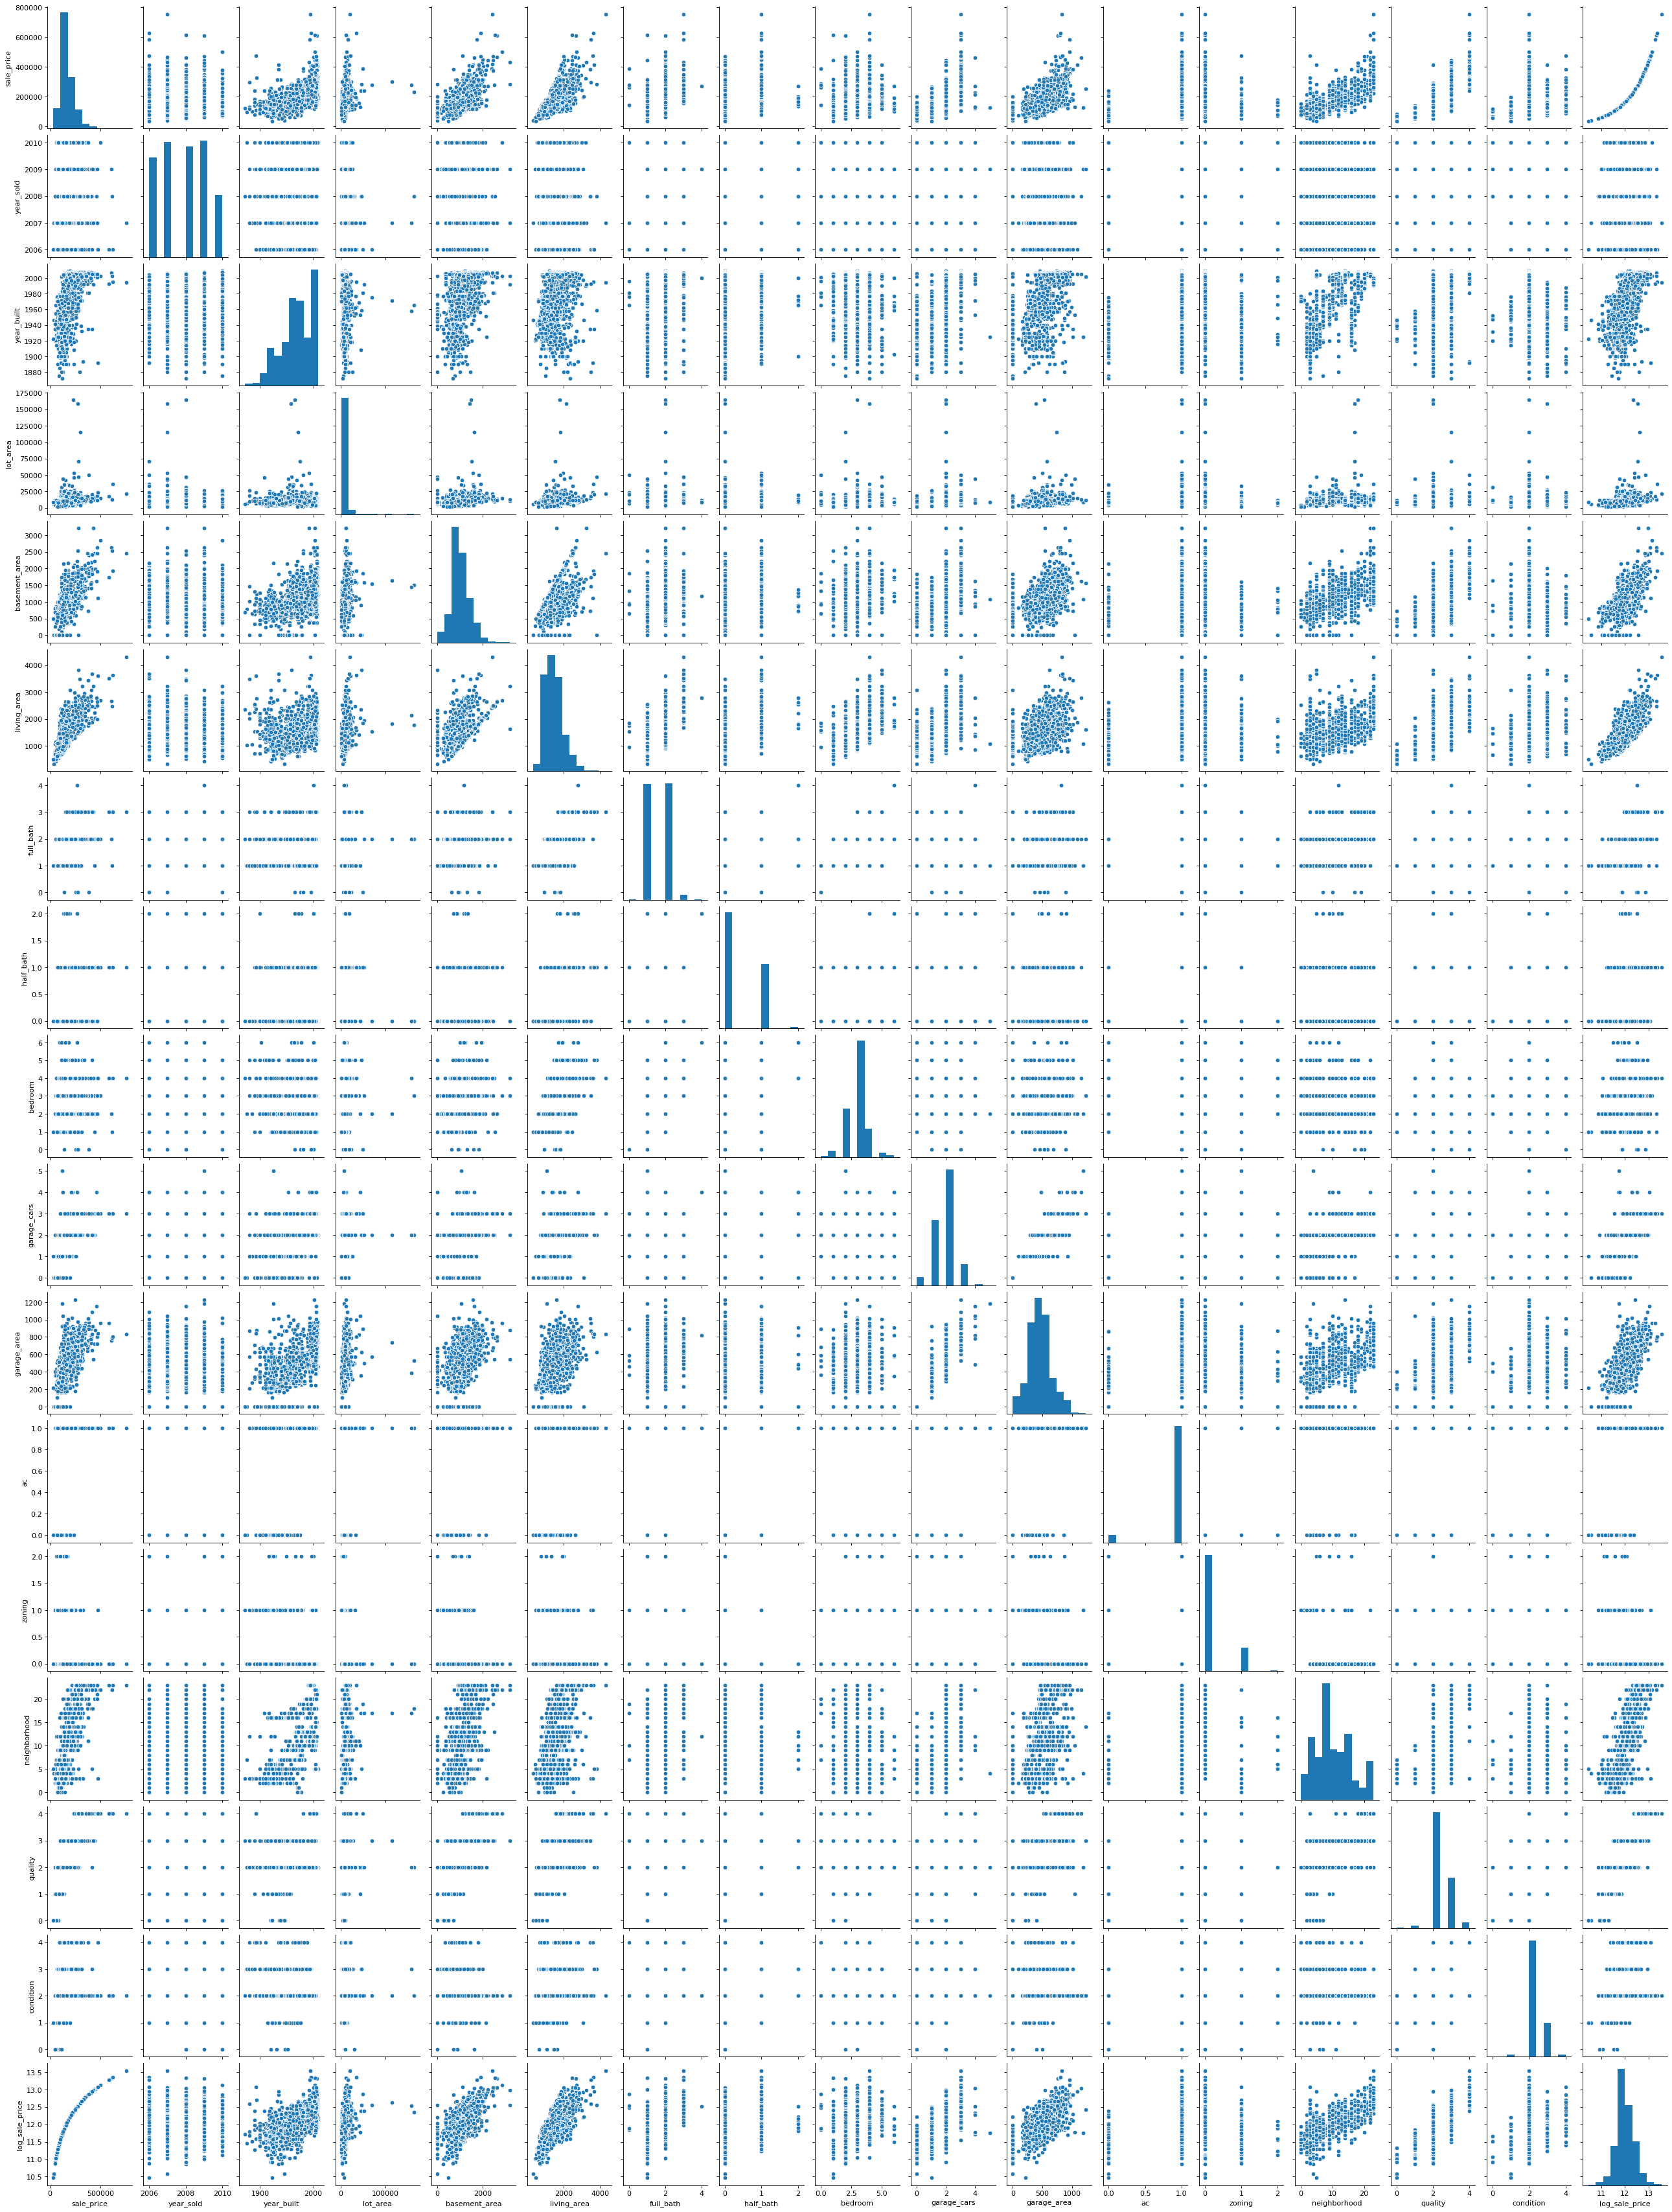

In [8]:
sns.pairplot(sales, aspect=0.75)

Mean: 174600.288510101
Median: 156225.0
Standard Deviation: 72010.43705178864


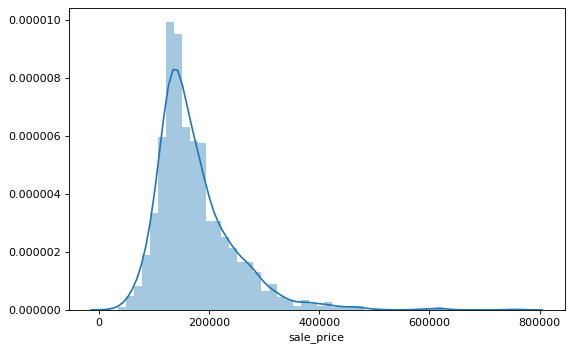

In [9]:
sns.distplot(sales["sale_price"])
print("Mean:", np.mean(sales["sale_price"]))
print("Median:", np.median(sales["sale_price"]))
print("Standard Deviation:", np.std(sales["sale_price"]))

`sale_price`
We can see that the distribution of the sale price is steep and highly righ skewed. I have also taken the natrual log of the sale price as a new column called `log_sale_price` so that it looks more like a normal distribution. I will also propose model on the scaled label, and then obtaining the prediction of the true label by exponentialization.

`year_sold`
All houses were sold in recent years from 2006 to 2010 inclusively, with the least number of sales in 2010. Theoretically, sale price should go up with respect to the year sold in a long term as the inflation goes, although it is possible that the price go down in a short term because of economic recession. But this is a very diverse pattern from city to city, e.g., it makes a lot of difference between the houses in Detroit and those in the New York City. Based on the data, this city is nowhere near any city like Detroit. Moreover, the market is doing alright in 2008. On the other hand, 5 years of inflation is hardly enough to drive the price to raise. There is no causation that I can think of nor strong relation between this feature and the sale price shown in the data. Therefore, I am interested in seeing how the model would perform without this feature.

`year_built`
It occurs to me that people would generally prefer newer houses for more advanced facilities and more stable structure. Realistically, older houses are prone to problems. Maybe some older hosues are outliers for this feature as they might have historical importance or etc., but in my opinion, newer houses are much more appealling. There is a strong reason for me to include this feature.

`lot_area`
Because of the outliers on the right, it looks like that those data points almost form a vertical line at first glance. However, if one looks closely, s/he will find that the price is generally positively correlated with the lot area. It also makes sense to me as Americans always dream for larger and larger houses. The bigger the better as the saying goes. It also cost more so it needs a higher price to make up for it. Morally. one should also pay more if s/he occupies more area of the earth. There is a strong reason for me to include this feature.

`basement_area`
A larger basement means larger storage space, and higher cost. There is no free lunch, and if the customer wants a bigger basement for whatever reason, s/he needs to pay for it. I believe this feature is needed.

`living_area`
This featrue shares a collinearity with `basement_area`, as the ground floor is usually built right on top of the basement with approximately the same square feet. This is probably the most significant feature in this dataset, as people buy houses for a spacious living area. 

`full_bath`
Oftentimes, in a house, a full bath is attached to the master bedroom and there should be at least another somewhere else so that people who sleep in guest bedrooms can take a shower without intruding the master bedroom. The more extravagance the house is, the more full bath there should be, so that people will have their privacy. The data also shows a strong relationship, therefore I belive this feature is also important.

`half_bath`
Although you cannot take a shower in a half bath, it can make up for the lack of full bath so that occupants do have to face a race condition and wait. But if one cannot afford a house with more bathrooms, then sadly s/he has to adapt to a cheaper house that cost less to build.

`bedroom`
Even though more bedrooms mean that the house can accommodate more people or guests, it may not have too much things to do with the price. Houses do not have to contain many bedrooms to make themselves more valuable. Houses with plenty of bedrooms are usually suitable for renting. Because the owner can lower the rent to attract tenants but still make a good profit as there are many bedrooms the owner can lease out. Then most  of those houses are for business in the real world where those tenants are the people who can not afford a house or even an apartment. As a result, I would also exclude this feature if possible.

`garage_cars`
People who owns more cars should be richer and can afford more expensive houses. Houses should be more pricey if they are targeted at those customers.

`garage_area`
Richer people need more areas so that they can park more cars. A larger garage area would also allow better flexibility on the usage of the garage. The owner can only use it to park cars if it can only fit in one or two cars, but with larger garage, the owner can do much more about it and maybe even start a business.

`ac`
A house without ac would be uncomfortable to live and must be cheaper...

`zoning`
It makes sense that more houses are in less populated area, and highly populated area can only contain a limited number of houses. However, the data does not show a strong correlation, and I do not know any causation between this feature and the sale price. Therefore, I would like to exclude it if possible.

`neighborhood`
I sorted the neighborhood so that they appear in the plot in an increasing order so that it would be easier to fit later in section 3. Different neighborhood has different safety level, schools and hospitals of different qualities. It might take more time to commute for certain neighborhoods. This feature implies those important factors that is included in the calculation of the housing price in the real world.

`quality` and `condition`
They are important factors as well. No rational people would pay a much higher price for a house that is either of a much lower quality or of a much lower condition without an outstanding reason.


To conclude, I would see what would happen if I exclude `year_sold`, `bedroom`, `zoning` as I question their relevance to the sale price. It is also easy to overfit the data with so many features and not so many training data, and a too complex model would be hard to interpret.


## 3. Model Fitting and Tuning

### 3.1 Rejected Models

I have tried with 6 different models in total on the data excluding those three features (`year_sold`, `bedroom` and `zoning`). I have also applied those model against all the features to make sure that I have not done something unreasonable. I also treated continuous variables and categorical variables differently.

#### 3.1.1 Linear Regression Model

The first model that I have tried is linear regression with feature selection (More details available in `linear_feature.ipynb`). I only fitted the model to the data and there was no hyperparameter tuning. 

When I train this model without feature selection, it seems to have overfit the data a little bit. (More details available in `linear.ipynb`)

#### 3.1.2 Polynomial Regression Model 

With feature selection, I fit the model on categorical variables with degree 1, and up to degree 3 with all continuous variables as the relationship should be simple and of lower order. I then used GridSearchCV to tune over the degrees. For more details, please see `poly_feature.ipynb`.

Without feature selection, I fit the model on all features in the same way above. For more details, please see `poly.ipynb`.

#### 3.1.3 Regression Tree Model

With feature selection, I fit the model on categorical variables with specified number of bins. For continuous variables, I used GridSearchCV to tune over the number of bins using 3, 5, 10, 15 respectively. For more details, please see `tree_feature.ipynb`.

Without feature selection, I fit the model on all features in the same way above. For more details, please see `tree.ipynb`.

#### 3.1.4 Combined Model of Polynomial Regression and Regression Tree

As I have experimented with the polynomial regression model and regression tree model, I was curious on what would happen if I combine both models. 

With feature selection, I applied regression tree on categorical variables, and polynomial regression on continuous variables. I also tuned the degree of the polynomial regression. For more details, please see `polytree_ipynb`.

I also experimented  this model on all features. For more details, please see`polytree_ipynb`.

#### 3.1.5 Linear Lasso Regression Model

With feature seleciton, I fitted a linear lasso regression model on the data and tuned the regularization parameter $\lambda$ over a set of values. For more details, please see `lasso_lin.ipynb`.

For more details on the model applied on all features, please see `lasso_lin_feature.ipynb`.

### 3.2 Preferred Model: Linear Ridge Regression Model

Overall, feature selection does not impact the accuracy negatively and sometimes helps the model to yield a better accuracy and reduce the overfiting problem. I also decided not to include any interactions in all models as there was no strong reason for me to do this. Among the 6 models, only the result from regression tree model is less impressive than others. The polynomial regression model and the combined model seem to overfit the training data. The linear regression model is the second best model in my opinion. As a very basic and simple model, it achieved a high accuracy and it seems it only slightly overfits the data. The lasso regression model is always trying to select the smallest $\lambda$ based on the result obtained from cross validation. The overfitting of linear regression model on the data is not severe enough for lasso to choose a larger $\lambda$. And by choosing any larger $\lambda$, lasso easily underfits the data. Therefore I then experimented with linear ridge regression model. This is also one of the simplest models. However, it is more accurate and it better fits the data. This regularized model is much less likely to overfit the data nor it underfits the data. Therefore I would like to choose this model. 

#### 3.2.1 On All Features:

In [10]:
# training features
X = StandardScaler().fit_transform(sales.loc[:, "year_sold": "condition"])

# testing features
X_test = StandardScaler().fit_transform(sales_test.loc[:, "year_sold": "condition"])

# training labels
log_y = sales["log_sale_price"]
y = sales["sale_price"]

# testing labels
y_test = sales_test["sale_price"]
log_y_test = np.log(sales_test["sale_price"])

# lambda
alphas = np.linspace(0, 15, num=151)

# tunning lambda
grid_search = GridSearchCV(Ridge(), param_grid={"alpha": alphas}, 
                           cv=KFold(5, True, random_state=2020), 
                           scoring="neg_root_mean_squared_error", 
                           verbose=1).fit(X, log_y)

print("Coefficients: ", grid_search.best_estimator_.coef_)
print("Intercept: ", grid_search.best_estimator_.intercept_)

print("\nbest index: ", grid_search.best_index_)
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

log_train_prediction = grid_search.best_estimator_.predict(X)
print("\ntraining log rmse", np.sqrt(mean_squared_error(log_y, log_train_prediction )))
print("training rmse", np.sqrt(mean_squared_error(y, np.exp(log_train_prediction ))))
print("log cross validation rmse", -1 * cross_val_score(grid_search.best_estimator_, X, log_y, 
                                                        cv=KFold(5, True, random_state=2020), 
                                                        scoring="neg_root_mean_squared_error"))

log_test_prediction = grid_search.best_estimator_.predict(X_test)
print("\ntesting log rmse", np.sqrt(mean_squared_error(log_y_test, log_test_prediction)))
print("testing rmse", np.sqrt(mean_squared_error(y_test, np.exp(log_test_prediction))))

Fitting 5 folds for each of 151 candidates, totalling 755 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Coefficients:  [-0.00026194  0.06250702  0.01940613  0.06620009  0.15943448 -0.00538829
  0.0052151  -0.02561228  0.02868376  0.02106638  0.02397032 -0.01787821
  0.05753429  0.06583396  0.0574548 ]
Intercept:  11.999189540962782

best index:  29
best param:  {'alpha': 2.9000000000000004}
best score:  -0.11595714197572538

training log rmse 0.11345774378150957
training rmse 20719.737511772008
log cross validation rmse [0.11443044 0.11425577 0.12137416 0.12377308 0.10595225]

testing log rmse 0.11636658734806832
testing rmse 21446.778568083453


[Parallel(n_jobs=1)]: Done 755 out of 755 | elapsed:   13.5s finished


I first standardized the training data on the all the training features. I used grid search to tune the regularization hyperparameter $\lambda$ over a set of values (151 datapoints from 0 to 15 including endpoint) to find the best value. Then I accquired the best estimator found during the grid search. I also standardized the testing features before testing.

#### 3.2.2 With Feature Selection

In [11]:
# training features
X = StandardScaler().fit_transform(
    sales.loc[:, "year_sold": "condition"].drop(
        columns=["year_sold", "bedroom", "zoning"]))

# testing features
X_test = StandardScaler().fit_transform(
    sales_test.loc[:, "year_sold": "condition"].drop(
    columns=["year_sold", "bedroom", "zoning"]))

# training labels
log_y = sales["log_sale_price"]
y = sales["sale_price"]

# testing labels
y_test = sales_test["sale_price"]
log_y_test = np.log(sales_test["sale_price"])

# lambda
alphas = np.linspace(0, 15, num=151)

# tuning lambda
grid_search = GridSearchCV(Ridge(), param_grid={"alpha": alphas}, 
                           cv=KFold(5, True, random_state=2020), 
                           scoring="neg_root_mean_squared_error", 
                           verbose=1).fit(X, log_y)

print("Coefficients: ", grid_search.best_estimator_.coef_)
print("Intercept: ", grid_search.best_estimator_.intercept_)

print("\nbest index: ", grid_search.best_index_)
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

log_train_prediction = grid_search.best_estimator_.predict(X)
print("\ntraining log rmse", np.sqrt(mean_squared_error(log_y, log_train_prediction )))
print("training rmse", np.sqrt(mean_squared_error(y, np.exp(log_train_prediction ))))
print("log cross validation rmse", -1 * cross_val_score(grid_search.best_estimator_, X, log_y, 
                                                        cv=KFold(5, True, random_state=2020), 
                                                        scoring="neg_root_mean_squared_error"))

log_test_prediction = grid_search.best_estimator_.predict(X_test)
print("\ntesting log rmse", np.sqrt(mean_squared_error(log_y_test, log_test_prediction)))
print("testing rmse", np.sqrt(mean_squared_error(y_test, np.exp(log_test_prediction))))

Fitting 5 folds for each of 151 candidates, totalling 755 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Coefficients:  [ 0.06513703  0.02193923  0.06747966  0.14041092 -0.0081849   0.00571861
  0.02652812  0.02378429  0.02275476  0.07042253  0.06789671  0.0575952 ]
Intercept:  11.999189540962782

best index:  80
best param:  {'alpha': 8.0}
best score:  -0.11804585913768155

training log rmse 0.11577913618758308
training rmse 21524.07547884282
log cross validation rmse [0.11663094 0.11766322 0.12427285 0.1231703  0.10849199]

testing log rmse 0.118551094167262
testing rmse 21777.852683510395


[Parallel(n_jobs=1)]: Done 755 out of 755 | elapsed:   11.5s finished


I first standardized the training data on those selected features. I used grid search to tune the regularization hyperparameter $\lambda$ over a set of values (151 datapoints from 0 to 15 including endpoint) to find the best value. Then I accquired the best estimator found during the grid search. I also standardized the testing features before testing.

We can see that the feature selection is successful. With similar performance and less overfitting, I would choose the linear ridge regression model with feature selection as my final model for its simplicity and better interpretability.

## 4. Discussion


My final model achieved a training rmse of `$21524.07547884282` and a testing rmse of `$21777.852683510395`. The model properly fit the training data, and performed similarly on the testing data. This demonstrate that this model is robust and stable. The model also yields a good though not nearly perfect accuracy. It can be used as a general guidline on the pricing of a house in this city. One can even use the information provided by the model to decide whether s/he should sell the house his/herself or hire a real-estate agent denpending on the cost of such hiring. It can be trusted to some degree. Another fantastic thing about this model is that it does not require labor and it is cheap. However, it cannot be employed to replace the pricing of a professional real-estate agent. They have much more domain expertise and can provide more accurate and reliable pricing.

From the model, the `sale_price` is mostly positively correlated with `living_area`. It is reasonable that customers are concern most about this characteristic of the house. There is also a strong correlation between the `neighborhood` and `sale_price`. It looks like real-estate is mostly about location. Customers do care where the house is located. 

The `sale_price` is also strongly positively correlated with `quality`, `basement_area`, `year_built`, `condition` (from the highest to lowest). Customers cares more about the `quality` than the temporary `condition`. The `sale_price` is also positively related to `garage_cars`, `garage_area`, `ac`, `lot_area`, `half_bath`. From my perspective, the space of the garage might be almost as important as that of the basement, but here we have two features so the weights get split between them. This is not saying that one of them should be exclude as cars and garage come in all shape and sizes, and larger garage does not necessarily always fit in more cars. Also, garage is not always used to park cars. It can be used in other ways such as starting Apple Inc. or something else. `ac`, `lot_area` are also essential factors in deciding the sale price which are also sensible. `half_bath` is also an important factor.

The `sale_price` is only negative correlated with `full_bath` in the model although it does not look like this in the plot. In my opinion, that is because the number of `full_bath` is positively correlated with the `living_area`. Also, `full_bath` requires more labor to maintain and keep clean. If people do not really need it, then having excessive `full_bath` is a little bit of a problem for the customer. They occupies area and space that can be put into other uses. 

## 5. Model Validation

*We have provided a third csv file called `sales_holdout.csv` which we will be using for assessing the predictive performance of your model. The file provided with the assignment contains **identical** data to `sales_test.csv`, however after you turn in your notebook we will be replacing this file with the true holdout data (350 additional house sales not included in the train or test set) and rerunning your notebook.*

*The objective of this is two-fold, the first is to ensure that your modeling code is reproducible and everything can be rerun and "identical" results can be obtained. And second, to obtain a reliable estimate of your final model's predictive performance, which will be compared across all of the projects in the course.*

*You should include a brief write up in the section detailing the performance of your model, in particular you should discuss the implications of this modeling uncertainty in the context of predicting house prices. For example, buyers and sellers are likely to care if the prediction is off by `$20,000` but are less likely to care if it is off by `$500`.*

In [12]:
sales_holdout = pd.read_csv("sales_holdout.csv")

# Adjust this code as necessary to preprocess the holdout data
X_holdout = sales_holdout.drop('sale_price', axis=1)
X_holdout.replace(encoding, inplace=True)
X_holdout = X_holdout.drop(columns=["year_sold", "bedroom", "zoning"])
X_holdout = X_holdout.select_dtypes(exclude='object')
X_holdout = StandardScaler().fit_transform(X_holdout)

y_holdout = sales_holdout.sale_price

In [13]:
# This is a placeholder model so the subsequent cell runs
# DELETE this cell once `final_model` or equivalent is defined
# in Section 3.

final_model = grid_search.best_estimator_

In [14]:
# Calculate the root mean squared error for your model
# 
# Change the name of `final_model` to reflect the name of your fitted model object
#
# Alternative metrics are acceptable here but require 
# justification in your write up

np.sqrt( mean_squared_error(y_holdout, np.exp(final_model.predict(X_holdout))) )

21777.852683510395